In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
rng = np.random.default_rng(12345)

inf_list = ['hs', 'phis', 'r_s', 'l_t']
SUMM_STAT_PATH = 'cell_inference/resources/orientation_geo_summ_stats.npy'
LFP_PATH = 'cell_inference/resources/orientation_geo_lfp.npy'
run_flag = True
number_samples = 1000

xs = np.full((number_samples,1), 0.) if 'xs' not in inf_list else rng.uniform(low=-50, high=50, size=(number_samples,1))
ys = np.full((number_samples,1), 0.) if 'ys' not in inf_list else rng.uniform(low=-2000, high=5000, size=(number_samples,1))
zs = np.full((number_samples,1), 50.) if 'zs' not in inf_list else rng.uniform(low=-50, high=50, size=(number_samples,1))
alphas = np.full((number_samples,1), np.pi/4) if 'alphas' not in inf_list else rng.uniform(low=-(np.pi / 3), high=(np.pi / 3), size=(number_samples,1))
hs = np.full((number_samples,1), 1.) if 'hs' not in inf_list else rng.uniform(low=-1., high=1., size=(number_samples,1))
phis = np.full((number_samples,1), 0.) if 'phis' not in inf_list else rng.uniform(low=0, high=np.pi, size=(number_samples,1))
loc_param = np.concatenate((xs, ys, zs, alphas, hs, phis), axis=1)

r_s = np.full((number_samples,1), 8.0) if 'r_s' not in inf_list else rng.uniform(low=5, high=12, size=(number_samples,1))
l_t = np.full((number_samples,1), 600.0) if 'l_t' not in inf_list else rng.uniform(low=20., high=800., size=(number_samples,1))
r_t = np.full((number_samples,1), 1.25) if 'r_t' not in inf_list else rng.normal(loc=((np.log(0.2) + np.log(1.0)) / 2), scale=((np.log(1.0) - np.log(0.2)) / 4), size=(number_samples,1))
r2_t = np.square(r_t)
clf = ClassifierBuilder()
clf.load_clf(paths.RESOURCES_ROOT + "gmax_lin_reg_classifier.joblib")
gmax = clf.predict(np.column_stack((r2_t, l_t)))
r_d = np.full((number_samples,1), .28) if 'r_d' not in inf_list else rng.normal(loc=((np.log(0.2) + np.log(1.0)) / 2), scale=((np.log(1.0) - np.log(0.2)) / 4), size=(number_samples,1))
r_tu = np.full((number_samples,1), .28) if 'r_tu' not in inf_list else rng.normal(loc=((np.log(0.2) + np.log(1.0)) / 2), scale=((np.log(1.0) - np.log(0.2)) / 4), size=(number_samples,1))
l_d = np.full((number_samples,1), 200.0) if 'l_d' not in inf_list else rng.normal(loc=((np.log(100) + np.log(300)) / 2), scale=((np.log(300) - np.log(100)) / 4), size=(number_samples,1))
geo_param = np.concatenate((r_s, l_t, r_t, r_d, r_tu, l_d), axis=1)

# geo_param = [8,600.,1.25,.28,.28,200.]
# geo_param = np.tile(geo_param, (number_samples, 1))

labels = np.concatenate((hs, phis, r_s, l_t), axis=1)#np.concatenate((loc_param, geo_param), axis=1)
np.set_printoptions(suppress=True)
print(loc_param.shape)
print(geo_param.shape)
print(labels.shape)

(1000, 6)
(1000, 6)
(1000, 4)


In [3]:
from typing import Union, List, Tuple
from matplotlib.figure import Figure
from matplotlib.axes import Axes

import os.path
if not os.path.isfile(SUMM_STAT_PATH) or not os.path.isfile(LFP_PATH) or run_flag:
    hf = h5py.File(paths.INVIVO_DATA_FILE, 'r')
    groundtruth_lfp = np.array(hf.get('data'))
    hf.close()

    sim = Simulation(geometry = geo_standard, 
                     electrodes = params.ELECTRODE_POSITION, 
                     cell_type = CellTypes.ACTIVE, 
                     loc_param = loc_param, 
                     geo_param = geo_param,
                     spike_threshold = -20, 
                     gmax = gmax, 
                     scale = 1., 
                     ncell = number_samples)
    # sim = Simulation(geo_standard,params.ELECTRODE_POSITION,loc_param,geo_param=geo_param,gmax=.001,scale=1000, ncell=ncell)  # gmax 0.001 -0.012
    sec_list = sim.cells[0].all

def plot_v(sim: Simulation, cell_idx: np.ndarray = np.array([0, 1]),
           figsize: Union[List[float],Tuple[float]] = (6,2)) -> Tuple[Figure, Axes]:
    t = sim.t()
    v = sim.v('all')
    fig, axs = plt.subplots(nrows=cell_idx.size, ncols=1)
    fig.set_size_inches(figsize[0],figsize[1]*cell_idx.size)
    for i,ax in enumerate(axs):
        ax.plot(t,v[i,:])
        ax.set_ylabel('Vm (mV)')
#         ax.legend(loc=1)
    axs[0].set_title('Membrane Voltage vs Time')
    axs[-1].set_xlabel('Time (ms)')
    plt.show()
    return fig, axs    

def valid_count(sim):
    # number of valid spiking cells
    nspk = sim.get_spike_number('all')
    print(nspk)
    nvalid = np.count_nonzero(nspk == 1)
    return nvalid

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

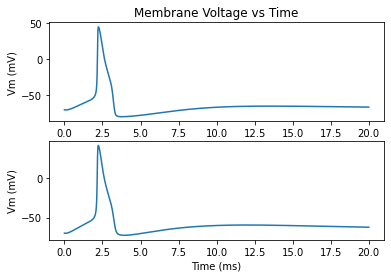

KeyboardInterrupt: 

In [4]:
from cell_inference.utils.feature_extractors.SummaryStats2D import build_lfp_grid, calculate_stats
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window

import os.path
if not os.path.isfile(SUMM_STAT_PATH) or not os.path.isfile(LFP_PATH) or run_flag:
    lfp_list = []
    summ_stat_list = []
    print("Number of valid sample: %d" % (valid_count(sim)))
    sim.run_neuron_sim()
    _ = plot_v(sim)

    # lfp_list = sim.get_lfp(np.arange(number_samples, dtype=int)).T

    for i in range(number_samples):
        lfp_list.append(sim.get_lfp(i).T)
        
        filt_b,filt_a = signal.butter(params.BUTTERWORTH_ORDER,
                              params.FILTER_CRITICAL_FREQUENCY,
                              params.BANDFILTER_TYPE,
                              fs=params.FILTER_SAMPLING_RATE)
        
        lfp_list[-1] = signal.lfilter(filt_b,filt_a,lfp_list[-1],axis=0) 
        
#         lfp_list[-1] /= np.max(np.abs(lfp_list[-1]))
    #     print(lfp_list[-1].shape)
        fst_idx = first_pk_tr(lfp_list[-1])
        start, end = get_spike_window(lfp_list[-1], win_size=params.WINDOW_SIZE, align_at=fst_idx-10)
        g_lfp, grid = build_lfp_grid(lfp_list[-1], params.ELECTRODE_POSITION, params.ELECTRODE_GRID)
        summ_stat_list.append(calculate_stats(g_lfp, grid))

    t = sim.t()
    lfp_list = np.reshape(np.transpose(np.stack(lfp_list, axis=-1)), (1000, 1, 384, 801))
    summ_stat_list = np.transpose(np.stack(summ_stat_list, axis=-1))
    np.save(SUMM_STAT_PATH, summ_stat_list)
    np.save(LFP_PATH, lfp_list)
else:
    lfp_list = np.load(LFP_PATH)
    summ_stat_list = np.load(SUMM_STAT_PATH)

In [ ]:
data = summ_stat_list
print(data.shape)

In [ ]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy
train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

In [ ]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 100, learning_rate=0.1, device=device)

In [ ]:
from sklearn.metrics import r2_score
x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()
print("R2: {}".format(r2_score(y, output)))
print(output.shape)
print(y.shape)

In [ ]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(14, 10))

# ax_x = plt.subplot(321)
# ax_x.scatter(y[:,0], output[:,0], c='red', marker='.')
# ax_x.set_xlabel('x real')
# ax_x.set_ylabel('x pred')

# ax_y = plt.subplot(322)
# ax_y.scatter(y[:,1], output[:,1], c='red', marker='.')
# ax_y.set_xlabel('y real')
# ax_y.set_ylabel('y pred')

# ax_z = plt.subplot(323)
# ax_z.scatter(y[:,2], output[:,2], c='red', marker='.')
# ax_z.set_xlabel('z real')
# ax_z.set_ylabel('z pred')

ax_p = plt.subplot(221)
ax_p.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_p.set_xlabel('phi real')
ax_p.set_ylabel('phi pred')

ax_h = plt.subplot(222)
ax_h.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_h.set_xlabel('h real')
ax_h.set_ylabel('h pred')

ax_s = plt.subplot(223)
ax_s.scatter(y[:,2], output[:,2], c='red', marker='.')
ax_s.set_xlabel('soma radius real')
ax_s.set_ylabel('soma radius pred')

ax_t = plt.subplot(224)
ax_t.scatter(y[:,3], output[:,3], c='red', marker='.')
ax_t.set_xlabel('trunk length real')
ax_t.set_ylabel('trunk length pred')

plt.show()

In [ ]:
%matplotlib notebook

idx = 0#[0, 1, 2, 3, 4, 5]

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(y[idx,0], y[idx,1], y[idx,2], c='green', marker='.')
ax.scatter3D(output[idx,0], output[idx,1], output[idx,2], c='red', marker='^')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()